In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from src.evaluate import calculate_class_accuracies, calculate_r2_scores
from src.rf import run_forest_class

train_features = pd.read_csv('./data/derived/feature_selection/training_data_with_dual.csv', index_col=0)
test_features = pd.read_csv('./data/derived/feature_selection/test_data_with_dual.csv', index_col=0)
combined = pd.concat([train_features, test_features])

#ADAPTIVE KNOT PLACEMENT
#train_features = pd.read_csv('./data/derived/feature_selection/training_data_adaptive_bspline.csv', index_col = 0)
#test_features = pd.read_csv('./data/derived/feature_selection/test_data_adaptive_bspline.csv', index_col = 0)


# 1 - EDA

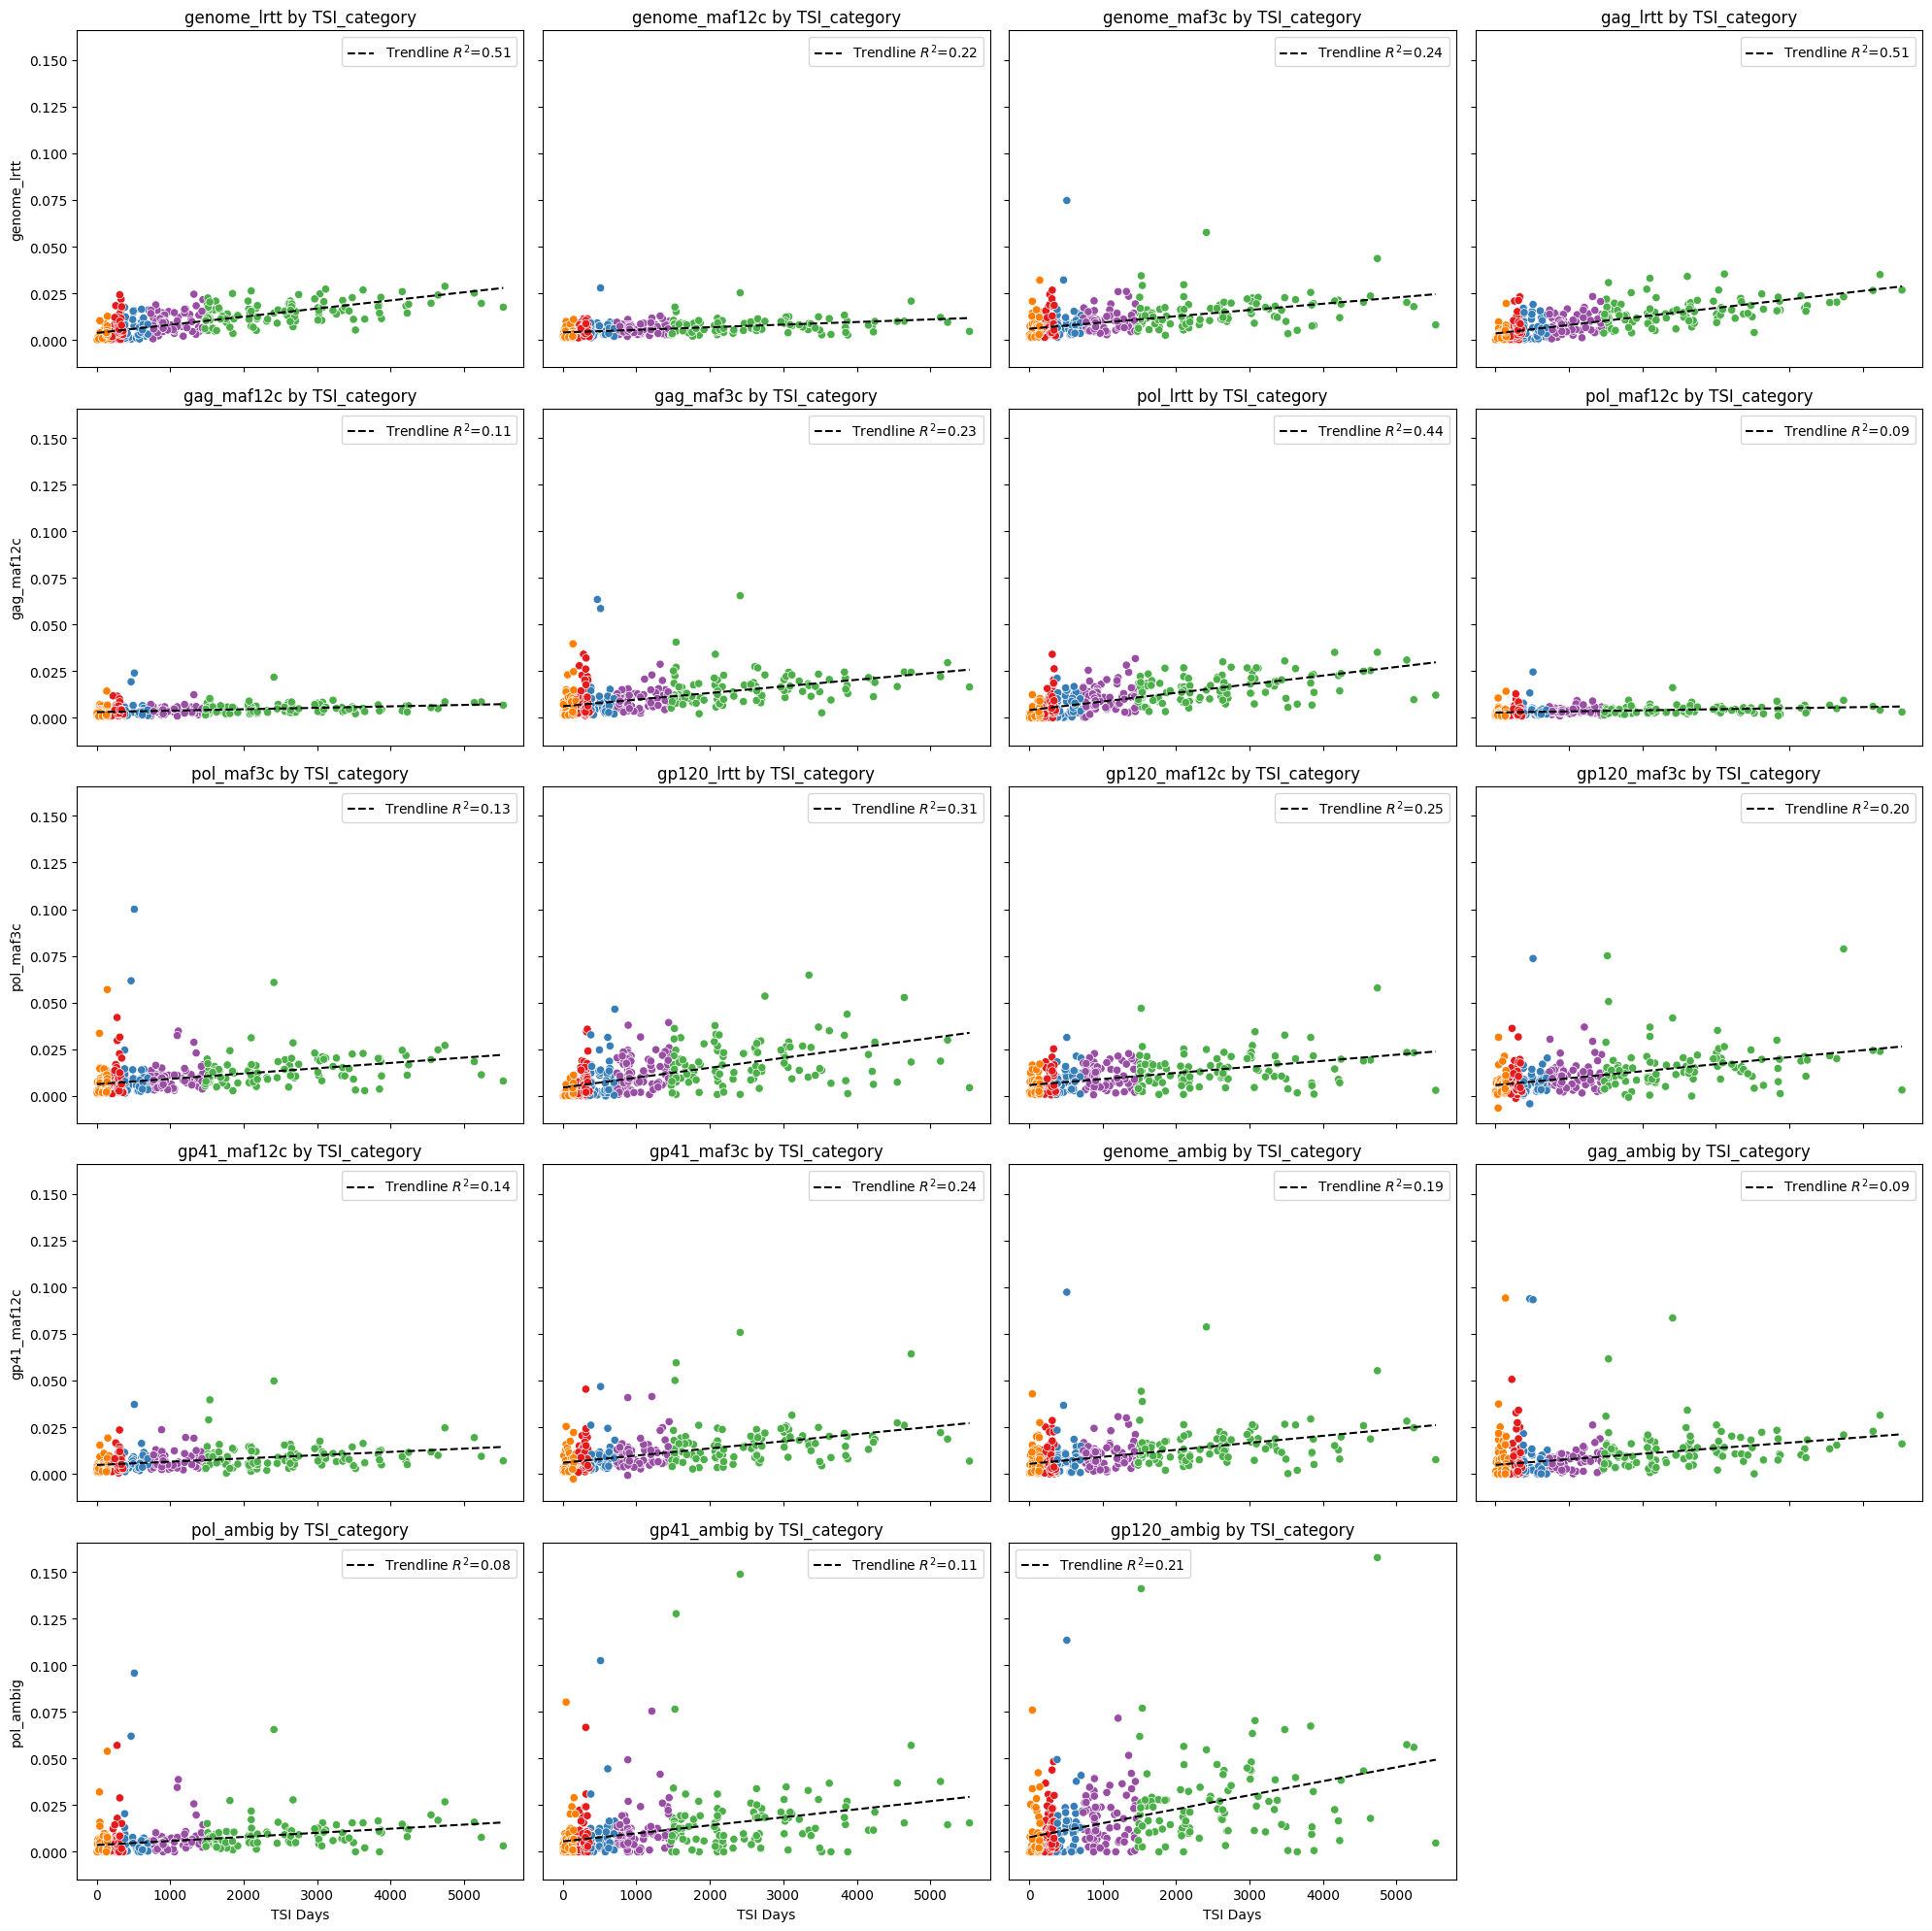

In [13]:
# List of features
features = [
    'genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 
    'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 
    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 
    'gp41_maf12c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 
    'gp120_ambig'
]

# Dictionary to store R² values
r2_values = {}

# Calculate R² values for each feature within each TSI category
for feature in features:
    r2_values[feature] = {}
    for category in train_features['TSI_category'].unique():
        subset = train_features[train_features['TSI_category'] == category]
        if len(subset) > 1:  # Ensure there are enough data points
            X = subset[['TSI_days']]
            y = subset[feature]
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            r2_values[feature][category] = r2
        else:
            r2_values[feature][category] = np.nan

# Plot features with R² values in titles
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    ax = axes[i]
    sns.scatterplot(ax=ax, data=train_features, x='TSI_days', y=feature, hue='TSI_category', palette='Set1', legend=False)
    ax.set_title(f'{feature} by TSI_category')
    ax.set_xlabel('TSI Days')
    ax.set_ylabel(feature)
    
    # Fit a linear regression model for the entire dataset
    subset = train_features.dropna(subset=[feature, 'TSI_days'])
    X = subset[['TSI_days']]
    y = subset[feature]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Add trendline
    sns.lineplot(ax=ax, x='TSI_days', y=y_pred, data=subset, color='black', label=f'Trendline $R^2$={r2:.2f}', linestyle='--')
    
    ax.legend()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('./outputs/features/tsi_corr_adaptive_bspline.png')
plt.show()

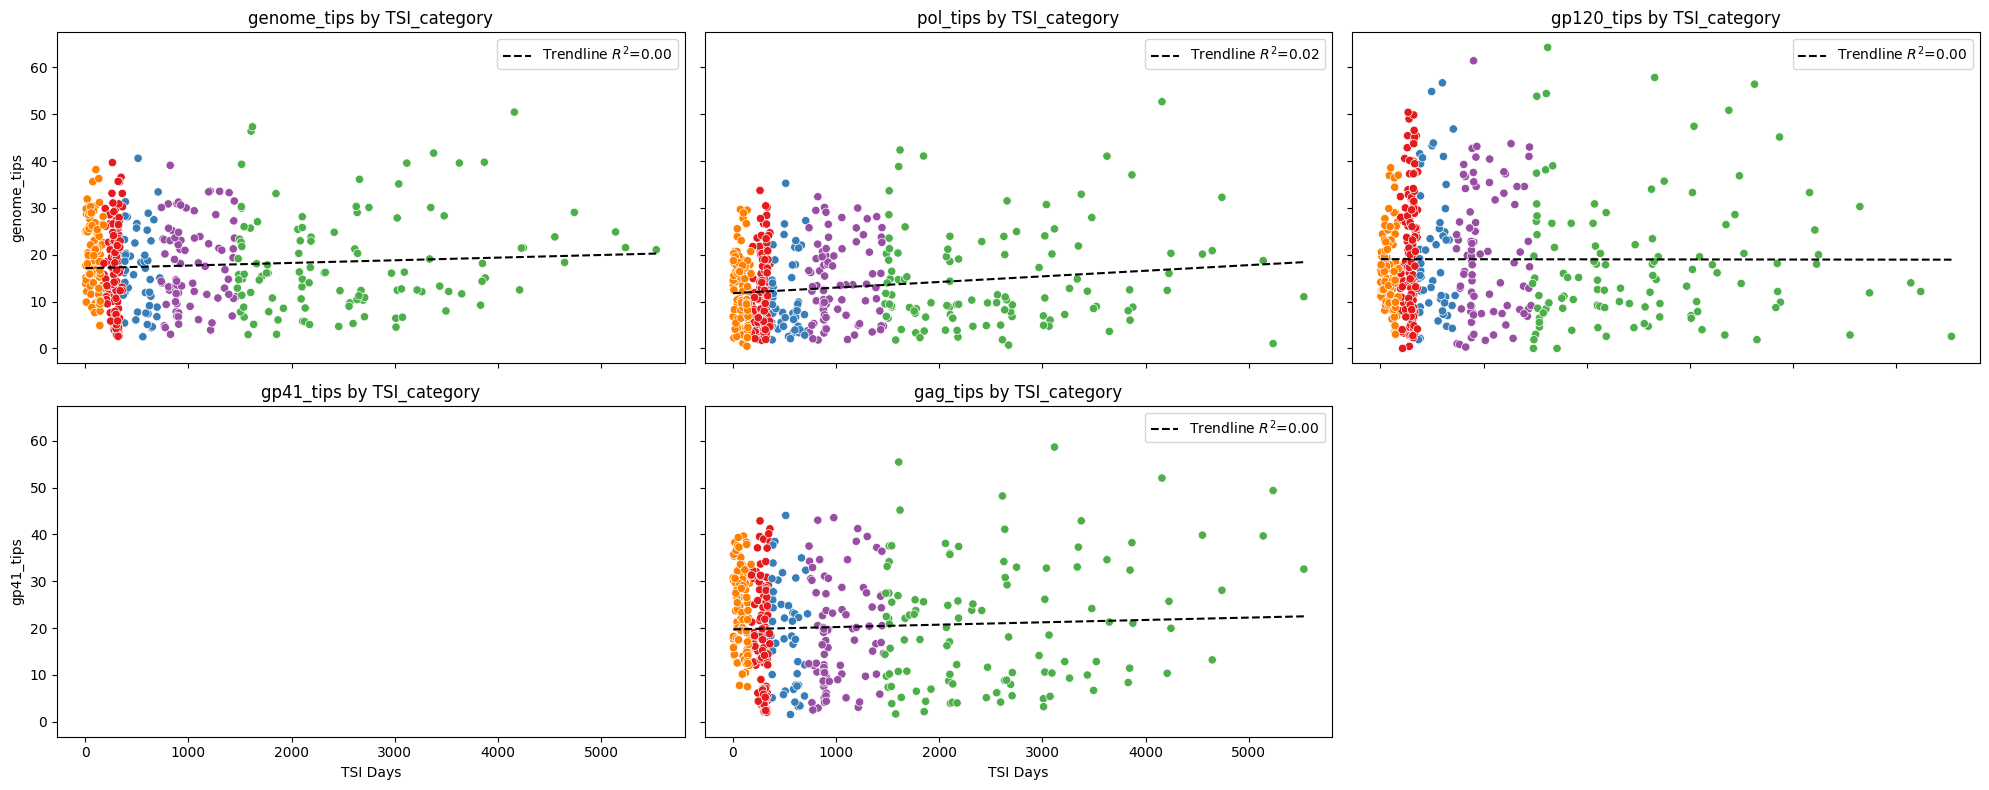

In [26]:
features_tips = ['genome_tips', 'pol_tips', 'gp120_tips', 'gp41_tips', 'gag_tips']
n_cols = 3
n_rows = int(np.ceil(len(features_tips) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, feature in enumerate(features_tips):
    ax = axes[i]
    sns.scatterplot(ax=ax, data=train_features, x='TSI_days', y=feature, hue='TSI_category', palette='Set1', legend=False)
    ax.set_title(f'{feature} by TSI_category')
    ax.set_xlabel('TSI Days')
    ax.set_ylabel(feature)
    
    # Fit a linear regression model
    subset = train_features.dropna(subset=[feature, 'TSI_days'])
    if len(subset) > 1:  # Ensure there are enough data points
        X = subset[['TSI_days']]
        y = subset[feature]
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        sns.lineplot(ax=ax, x='TSI_days', y=y_pred, data=subset, color='black', label=f'Trendline $R^2$={r2:.2f}', linestyle='--') #trendline
        
        ax.legend()
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('./outputs/features/tips_corr.png')
plt.show()

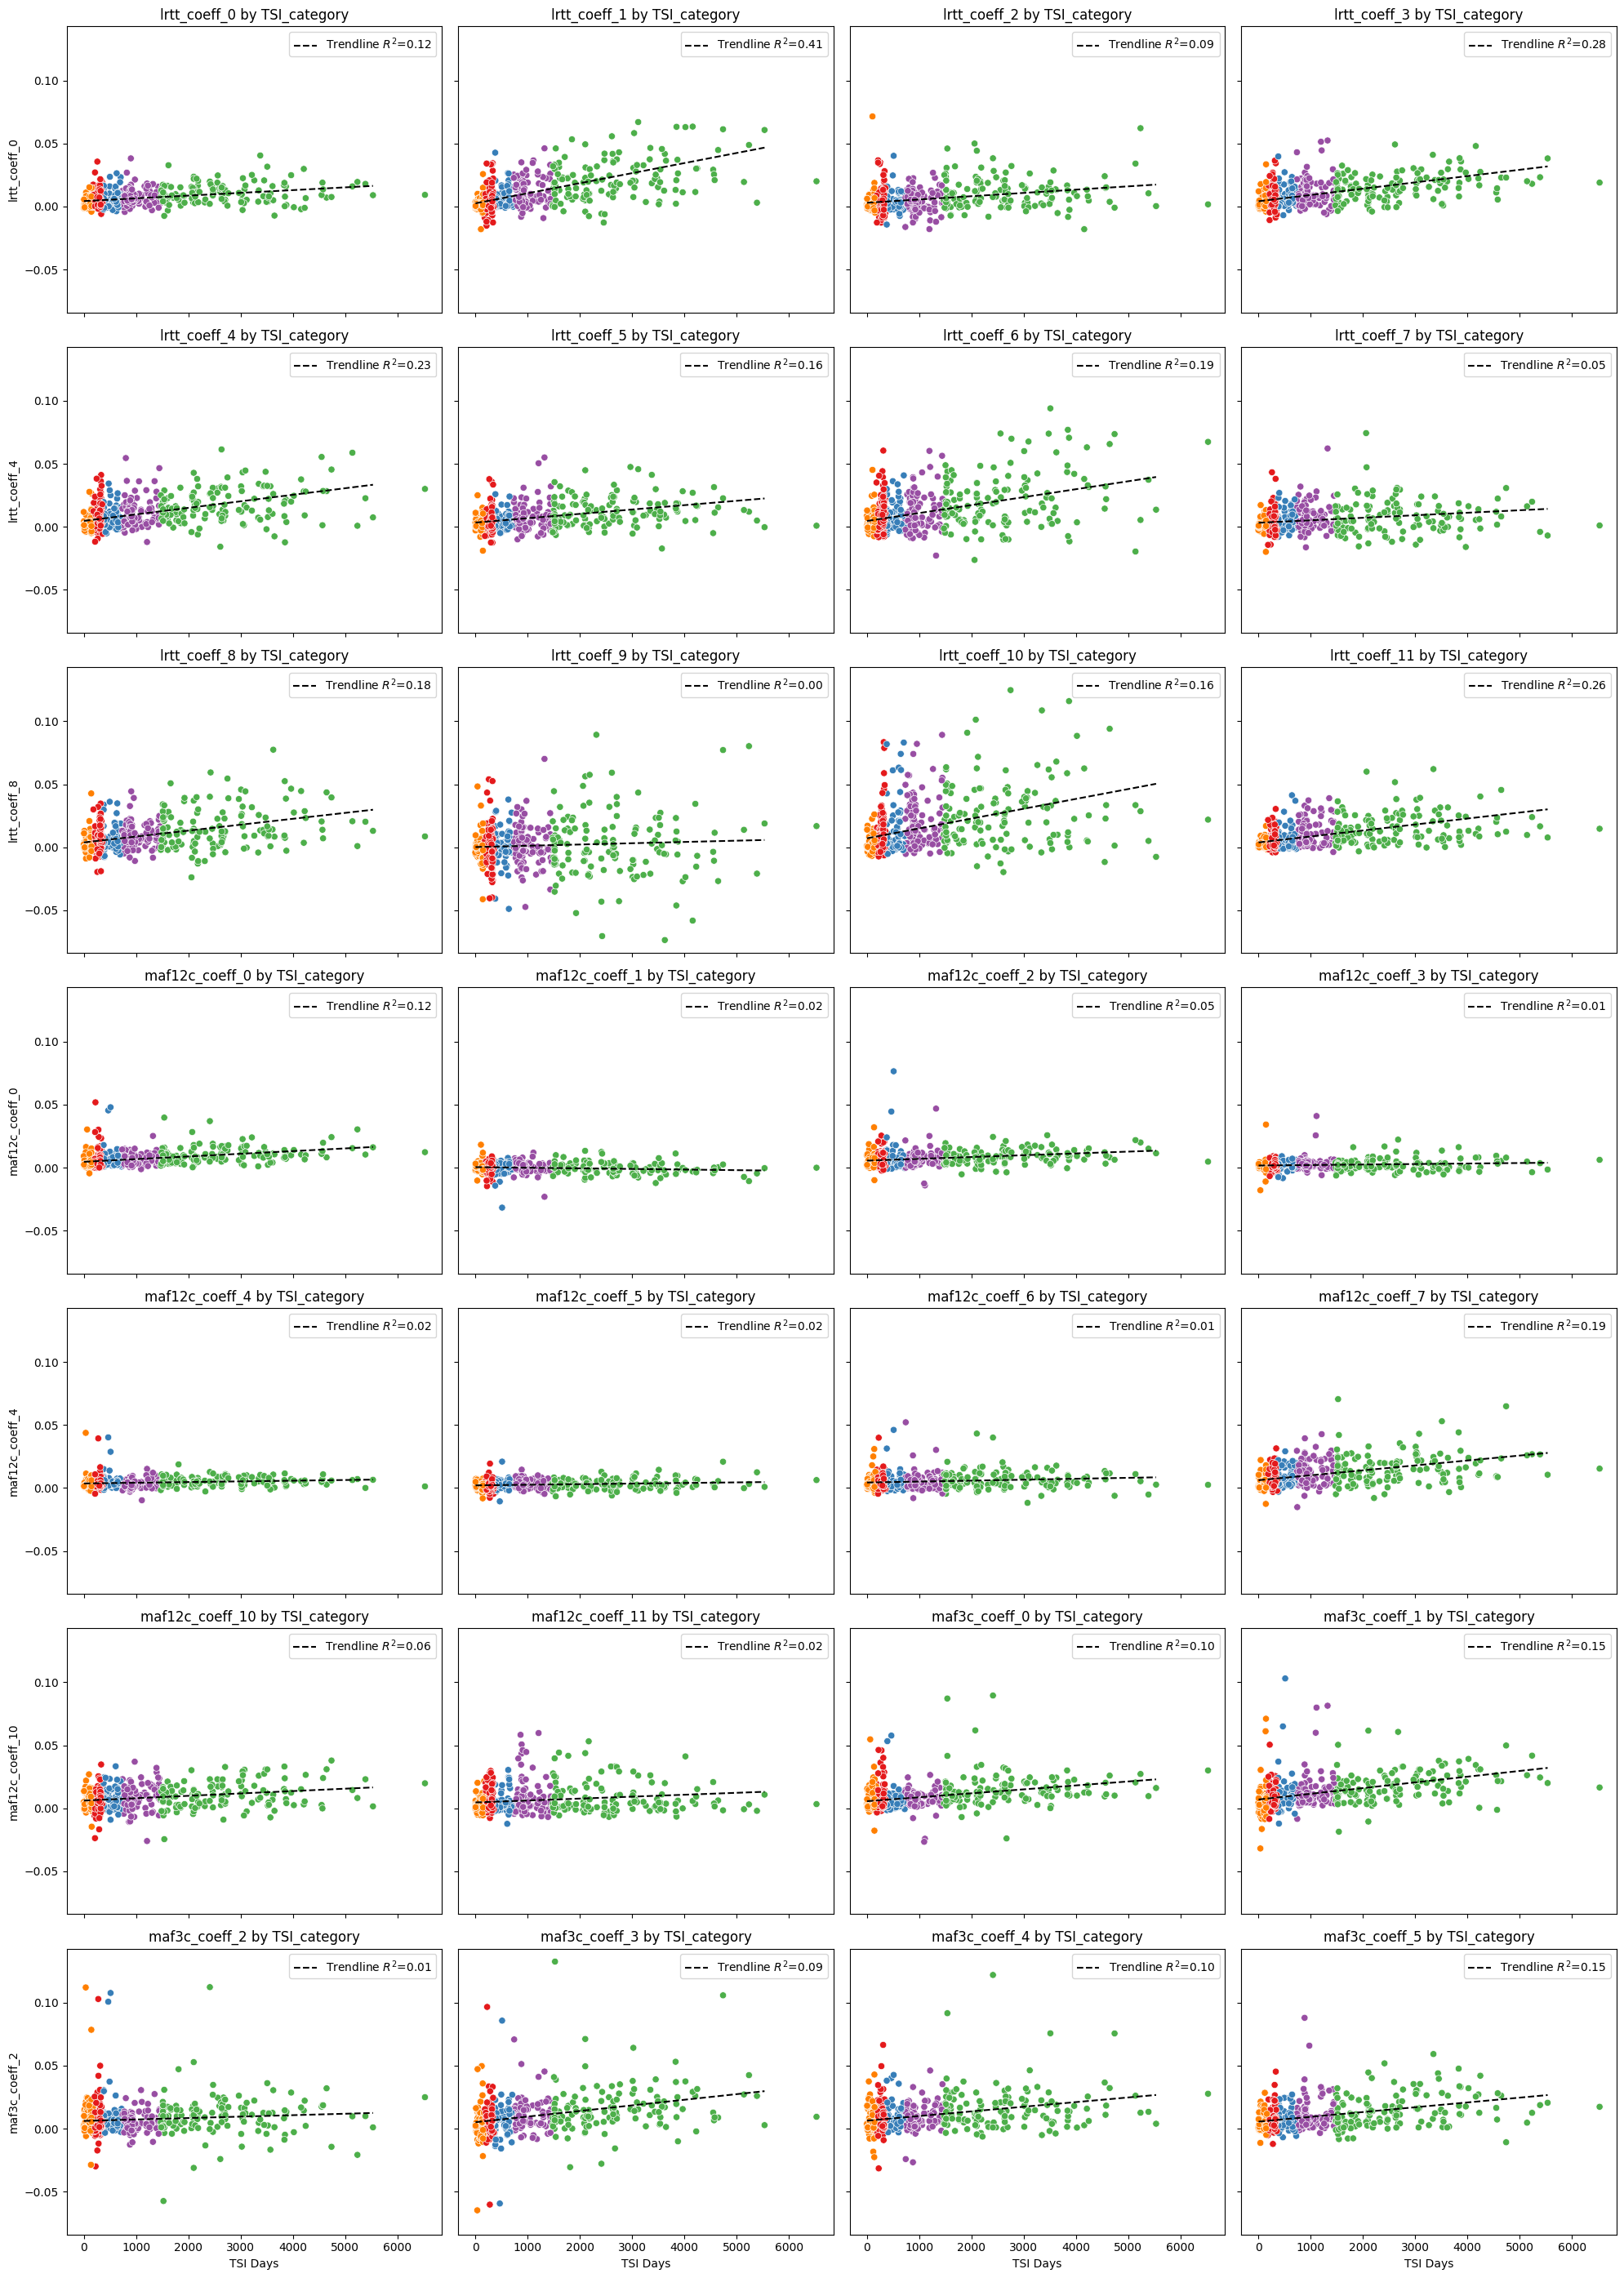

In [3]:
train = pd.read_csv('./data/derived/bspline_coeffs/training_data_with_bspline_coeffs.csv', index_col=0)
test = pd.read_csv('./data/derived/bspline_coeffs/test_data_with_bspline_coeffs.csv', index_col=0)
combined = pd.concat([train, test])
#  List of features
features = ['lrtt_coeff_0', 'lrtt_coeff_1', 'lrtt_coeff_2', 'lrtt_coeff_3', 'lrtt_coeff_4', 'lrtt_coeff_5', 
            'lrtt_coeff_6', 'lrtt_coeff_7', 'lrtt_coeff_8', 'lrtt_coeff_9', 'lrtt_coeff_10', 'lrtt_coeff_11', 
            'maf12c_coeff_0', 'maf12c_coeff_1', 'maf12c_coeff_2', 'maf12c_coeff_3', 'maf12c_coeff_4', 'maf12c_coeff_5', 
            'maf12c_coeff_6', 'maf12c_coeff_7', 'maf12c_coeff_10', 'maf12c_coeff_11', 
            'maf3c_coeff_0', 'maf3c_coeff_1', 'maf3c_coeff_2', 'maf3c_coeff_3', 'maf3c_coeff_4', 'maf3c_coeff_5'
            ]

# Dictionary to store R² values
r2_values = {}

# Calculate R² values for each feature within each TSI category
for feature in features:
    r2_values[feature] = {}
    for category in combined['TSI_category'].unique():
        subset = combined[combined['TSI_category'] == category]
        if len(subset) > 1:  # Ensure there are enough data points
            X = subset[['TSI_days']]
            y = subset[feature]
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            r2_values[feature][category] = r2
        else:
            r2_values[feature][category] = np.nan

# Plot features with R² values in titles
n_cols = 4
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows), sharex=True, sharey=True)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    ax = axes[i]
    sns.scatterplot(ax=ax, data=combined, x='TSI_days', y=feature, hue='TSI_category', palette='Set1', legend=False)
    ax.set_title(f'{feature} by TSI_category')
    ax.set_xlabel('TSI Days')
    ax.set_ylabel(feature)
    
    # Fit a linear regression model for the entire dataset
    subset = train.dropna(subset=[feature, 'TSI_days'])
    X = subset[['TSI_days']]
    y = subset[feature]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Add trendline
    sns.lineplot(ax=ax, x='TSI_days', y=y_pred, data=subset, color='black', label=f'Trendline $R^2$={r2:.2f}', linestyle='--')
    
    ax.legend()

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('./outputs/features/tsi_corr_bspline_coeffs.png')
plt.show()

# 2 - CLASSIFIER WITH DIFF FEATURE SETS

In [3]:
#DEFINE FEATURE SETS 
predictor_sets = {
    'Alex':    ["gag_lrtt", "gag_tips", "gag_maf3c", "pol_lrtt", "gp120_lrtt", "gp120_tips", "gp41_tips" ,"gp41_maf12c","gp41_maf3c", 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Genome':  ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig'],
    'ENV':     ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig'],
    'GAG_ENV': ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gp120_ambig'],
    'All':     ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 'pol_lrtt', 'pol_tips',
                'pol_maf12c', 'pol_maf3c', 'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips' , 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'], 
    'Andrea':  ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c','gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig'],
    'RFECV': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c']}

# DEFINE X AND Y 
X_train = train_features.drop(columns=['TSI_category'])
y_train = train_features['TSI_category']
X_test = test_features.drop(columns=['TSI_category'])
y_test = test_features['TSI_category']

#RUN RANDOM FOREST CLASSIFIER FOR EACH PREDICTOR SET 
results = []
for set_name, predictors in predictor_sets.items():
    accuracy = run_forest_class(X_train, y_train, X_test, y_test, predictors, max_depth = 10, min_samples_leaf= 4, min_samples_split= 10)
    results.append({'Predictor Set': set_name, 'Accuracy': accuracy})

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='Accuracy', ascending=False))

    Predictor Set  Accuracy
5  Genome_ENV_GAG  0.567742
6          Andrea  0.567742
0            Alex  0.561290
7           RFECV  0.548387
4             All  0.541935
1          Genome  0.529032
3         GAG_ENV  0.516129
2             ENV  0.470968


# CLASS ACCURACIES AND R2 SCORE 

In [4]:
predictor_sets = {
    'Alex':           ["gag_lrtt", "gag_tips", "gag_maf3c", 
                        "pol_lrtt", 
                        "gp120_lrtt", "gp120_tips", 
                        "gp41_tips" ,"gp41_maf12c", "gp41_maf3c"],
    'Genome':         ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips'],
    'ENV':            ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'],
    'GAG_ENV':        ['gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                       'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips'],
    'All':            ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                        'gag_lrtt', 'gag_tips', 'gag_maf12c', 'gag_maf3c', 
                        'pol_lrtt', 'pol_tips', 'pol_maf12c', 'pol_maf3c', 
                        'gp120_lrtt', 'gp120_tips', 'gp120_maf12c', 'gp120_maf3c', 
                        'gp41_lrtt', 'gp41_tips','gp41_maf12c', 'gp41_maf3c'],
    'Genome_ENV_GAG': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                       'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 
                       'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c'], 
    'Andrea':          ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c',
                        'gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 
                        'gp41_maf3c'],
    'RFECV':            ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                        'gp41_maf12c', 'gp41_maf3c']}


In [5]:
# Encode the TSI_category
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
train_features['TSI_encoded'] = ordinal_encoder.fit_transform(train_features[['TSI_category']])
test_features['TSI_encoded'] = ordinal_encoder.fit_transform(test_features[['TSI_category']])

#NUMBER OF CV FOLDS
min_class_size = train_features['TSI_encoded'].value_counts().min()
n_splits = min(10, min_class_size) 
print(n_splits)

10


In [6]:
accuracy_results = {}
r2_results = {}

for set_name, predictors in predictor_sets.items():
    class_accuracies_mean, class_accuracies_ci = calculate_class_accuracies(train_features, predictors)
    accuracy_results[set_name] = {
        'class_accuracies_mean': class_accuracies_mean,
        'class_accuracies_ci': class_accuracies_ci
    }
    
    mean_r2, r2_ci = calculate_r2_scores(train_features, predictors)
    r2_results[set_name] = {
        'mean_r2': mean_r2,
        'r2_ci': r2_ci
    }

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


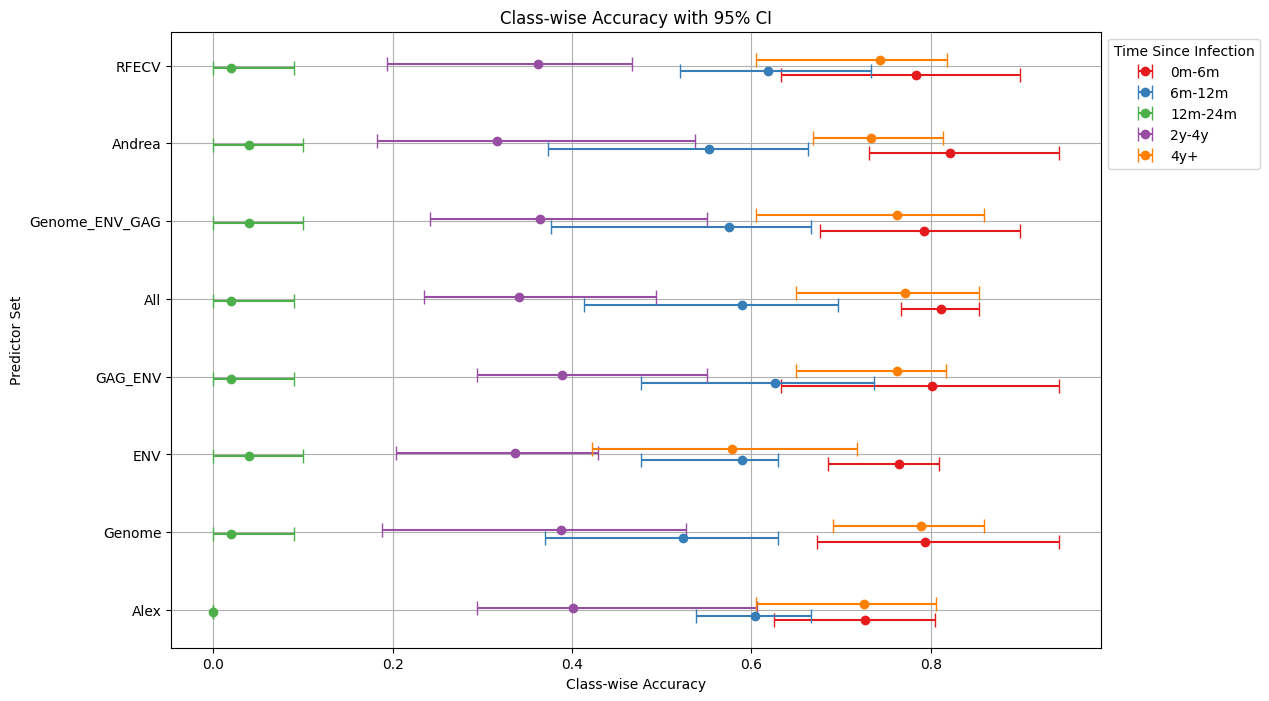

"# Plot R2 results with fixed shift\nfig, ax = plt.subplots(1, 1, figsize=(12, 8))\n\nfor i, (set_name, result) in enumerate(r2_results.items()):\n    mean_r2 = result['mean_r2']\n    r2_ci = result['r2_ci']\n    ax.errorbar(mean_r2, i, xerr=[[mean_r2 - r2_ci[0]], [r2_ci[1] - mean_r2]], fmt='o', capsize=5, label=set_name)\n\nax.set_xlabel('R2 Score')\nax.set_ylabel('Predictor Set')\nax.set_title('R2 Score with 95% CI')\nax.set_yticks(np.arange(len(r2_results)))\nax.set_yticklabels(r2_results.keys())\nax.grid(True)\nplt.show()"

In [8]:
category_names = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']

plot_data = []
for set_name, result in accuracy_results.items():
    class_accuracies_mean = result['class_accuracies_mean']
    class_accuracies_ci = result['class_accuracies_ci']
    
    for label, mean in class_accuracies_mean.items():
        ci = class_accuracies_ci[label]
        plot_data.append({
            'Predictor Set': set_name,
            'Class': label,
            'Mean Accuracy': mean,
            'CI Lower': ci[0],
            'CI Upper': ci[1]
        })

plot_df = pd.DataFrame(plot_data)

fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each class
colors = sns.color_palette("Set1", len(plot_df['Class'].unique()))

# Define a fixed shift for each class
class_shift = 0.05
classes = plot_df['Class'].unique()

# Plot class-wise accuracies with fixed shift
for i, set_name in enumerate(plot_df['Predictor Set'].unique()):
    subset = plot_df[plot_df['Predictor Set'] == set_name]
    for j, (class_label, class_subset) in enumerate(subset.groupby('Class')):
        shift = (j - len(classes) / 2) * class_shift  # Shift each class by a fixed amount
        ax.errorbar(class_subset['Mean Accuracy'], i + shift, 
                    xerr=[class_subset['Mean Accuracy'] - class_subset['CI Lower'], class_subset['CI Upper'] - class_subset['Mean Accuracy']], 
                    fmt='o', capsize=5, color=colors[j], label=f'{category_names[int(class_label)]}' if i == 0 else "")
    
ax.set_xlabel('Class-wise Accuracy')
ax.set_ylabel('Predictor Set')
ax.set_title('Class-wise Accuracy with 95% CI')
ax.legend(title='Time Since Infection', bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_yticks(np.arange(len(plot_df['Predictor Set'].unique())))
ax.set_yticklabels(plot_df['Predictor Set'].unique())
ax.grid(True)
plt.savefig('./outputs/classifier/class_accuracy.png')
plt.show()

'''# Plot R2 results with fixed shift
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

for i, (set_name, result) in enumerate(r2_results.items()):
    mean_r2 = result['mean_r2']
    r2_ci = result['r2_ci']
    ax.errorbar(mean_r2, i, xerr=[[mean_r2 - r2_ci[0]], [r2_ci[1] - mean_r2]], fmt='o', capsize=5, label=set_name)

ax.set_xlabel('R2 Score')
ax.set_ylabel('Predictor Set')
ax.set_title('R2 Score with 95% CI')
ax.set_yticks(np.arange(len(r2_results)))
ax.set_yticklabels(r2_results.keys())
ax.grid(True)
plt.show()'''

# OPTIMAL FEATURES

In [2]:
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c']
# DEFINE X AND Y 
X_train = train_features[features_derived]
y_train = train_features['TSI_category']
X_test = test_features[features_derived]
y_test = test_features['TSI_category']

In [3]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
230 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.41      0.62      0.49        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.35      0.40      0.37        20
         4y+       0.76      0.76      0.76        29
      6m-12m       0.59      0.61      0.60        64

    accuracy                           0.54       155
   macro avg       0.42      0.48      0.44       155
weighted avg       0.49      0.54      0.51       155



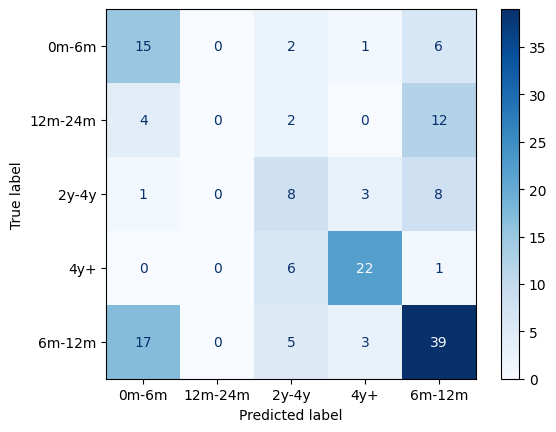

Accuracy: 0.5419354838709678
Balanced accuracy: 0.4785991379310344


"\nFOR SET KNOTS: \nBest Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}\naccuracy = 0.55 \n\nFOR ADAPTIVE KNOTS:\n\n"

In [4]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

'''
FOR SET KNOTS: 
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
accuracy = 0.55 

FOR ADAPTIVE KNOTS:

'''

# LOOCV

In [12]:
from sklearn.model_selection import LeaveOneOut

# Initialize the model with the best parameters
best_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Features and target variable for the combined dataset
X = combined[features_derived]
y = combined['TSI_category']
# Perform LOOCV
loo = LeaveOneOut()
loo_scores = cross_val_score(best_model, X, y, cv=loo, scoring='accuracy', n_jobs=-1)

# Calculate the mean accuracy and confidence interval
mean_accuracy = np.mean(loo_scores)
conf_interval = np.percentile(loo_scores, [2.5, 97.5])

print(f"LOOCV Mean Accuracy: {mean_accuracy:.4f}")
print(f"LOOCV 95% Confidence Interval: {conf_interval}")

LOOCV Mean Accuracy: 0.5775
LOOCV 95% Confidence Interval: [0. 1.]


# COST MATRIX

In [22]:
classes = np.array(['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+'])
cost_matrix = np.array([
    [0, 1, 2, 4, 5],  # 0m-6m
    [1, 0, 1, 3, 4],  # 6m-12m
    [2, 1, 0, 2, 3],  # 12m-24m
    [4, 3, 2, 0, 1],  # 2y-4y
    [5, 4, 3, 1, 0]   # 4y+
])

y = combined['TSI_category']
X = combined[features_derived]

In [23]:
def create_sample_weights(y, cost_matrix, classes):
    class_indices = {cls: idx for idx, cls in enumerate(classes)}
    sample_weights = np.ones_like(y, dtype=float)
    
    for i, label in enumerate(y):
        correct_class_index = class_indices[label]
        sample_weights[i] = cost_matrix[correct_class_index].sum()
    
    return sample_weights

y_indices = np.vectorize(lambda x: np.where(classes == x)[0][0])(y)
sample_weights = create_sample_weights(y, cost_matrix, classes)

In [25]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_train, y_train, sample_weight=sample_weights[:len(X_train)])
best_model = grid_search.best_estimator_

#PREDICT
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
357 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Balanced accuracy: 0.4921408045977012

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.41      0.71      0.52        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.35      0.40      0.37        20
         4y+       0.73      0.76      0.75        29
      6m-12m       0.62      0.59      0.61        64

    accuracy                           0.55       155
   macro avg       0.42      0.49      0.45       155
weighted avg       0.50      0.55      0.52       155



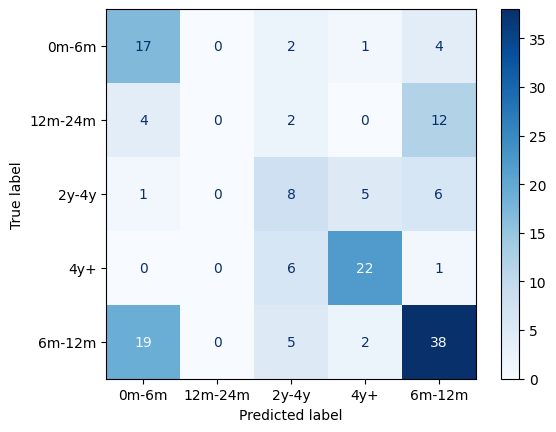

In [28]:
print("Best Parameters:", grid_search.best_params_)
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(class_report)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# BSPLINE COEFFICIENTS ADDED

In [7]:
features_derived = ['genome_lrtt', 'genome_tips', 'gag_lrtt', 'gag_tips', 'pol_lrtt', 'pol_tips', 'gp120_lrtt', 'gp120_tips', 'genome_maf12c', 'genome_maf3c', 'gag_maf12c', 'gag_maf3c', 'pol_maf12c', 'pol_maf3c', 'gp120_maf12c', 'gp120_maf3c', 'gp41_maf12c', 'gp41_maf3c', 
                    'lrtt_coeff_0', 'lrtt_coeff_1', 'lrtt_coeff_2', 'lrtt_coeff_3', 'lrtt_coeff_4', 'lrtt_coeff_5', 
                    'lrtt_coeff_6', 'lrtt_coeff_7', 'lrtt_coeff_8', 'lrtt_coeff_9', 'lrtt_coeff_10', 'lrtt_coeff_11', 
                    'maf12c_coeff_0', 'maf12c_coeff_1', 'maf12c_coeff_2', 'maf12c_coeff_3', 'maf12c_coeff_4', 
                    'maf12c_coeff_5', 'maf12c_coeff_6', 'maf12c_coeff_7', 'maf12c_coeff_10', 'maf12c_coeff_11', 
                    'maf3c_coeff_0', 'maf3c_coeff_1', 'maf3c_coeff_2', 'maf3c_coeff_3', 'maf3c_coeff_4', 'maf3c_coeff_5', 
                    'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']

#load datasets
train = pd.read_csv('./data/derived/bspline_coeffs/training_data_with_bspline_coeffs.csv', index_col=0)
test = pd.read_csv('./data/derived/bspline_coeffs/test_data_with_bspline_coeffs.csv', index_col=0)
combined = pd.concat([train, test])

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [4]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
336 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.46      0.67      0.54        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.33      0.25      0.29        20
         4y+       0.74      0.86      0.79        29
      6m-12m       0.56      0.62      0.59        64

    accuracy                           0.55       155
   macro avg       0.42      0.48      0.44       155
weighted avg       0.48      0.55      0.51       155



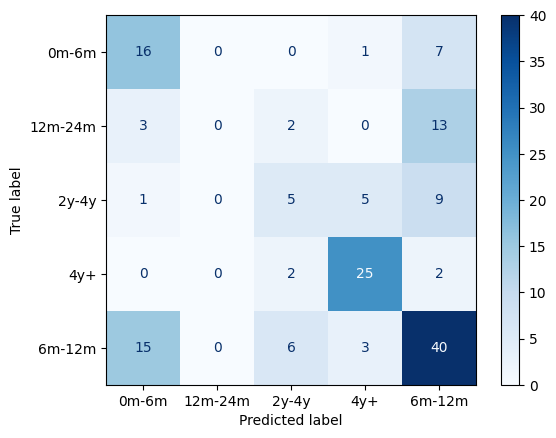

Accuracy: 0.5548387096774193
Balanced accuracy: 0.48074712643678164


In [6]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

### LOOCV

In [8]:
from sklearn.model_selection import LeaveOneOut

# Initialize the model with the best parameters
best_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Features and target variable for the combined dataset
X = combined[features_derived]
y = combined['TSI_category']
# Perform LOOCV

loo = LeaveOneOut()
loo_scores = cross_val_score(best_model, X, y, cv=loo, scoring='accuracy', n_jobs=-1)

# Calculate the mean accuracy and confidence interval
mean_accuracy = np.mean(loo_scores)
conf_interval = np.percentile(loo_scores, [2.5, 97.5])

print(f"LOOCV Mean Accuracy: {mean_accuracy:.4f}")
print(f"LOOCV 95% Confidence Interval: {conf_interval}")

LOOCV Mean Accuracy: 0.5728
LOOCV 95% Confidence Interval: [0. 1.]


# MY OWN FEATURE SET 1.0

In [8]:
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_ambig',
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                    'gp41_maf12c', 'gp41_maf3c',
                    'lrtt_coeff_1']

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
281 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.45      0.71      0.55        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.32      0.40      0.36        20
         4y+       0.73      0.76      0.75        29
      6m-12m       0.65      0.62      0.63        64

    accuracy                           0.56       155
   macro avg       0.43      0.50      0.46       155
weighted avg       0.51      0.56      0.53       155



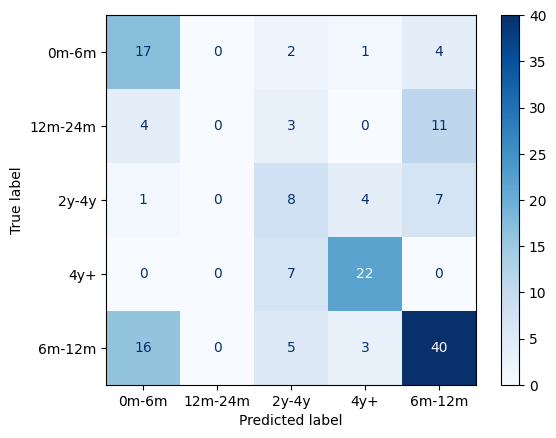

Accuracy: 0.5612903225806452
Balanced accuracy: 0.4983908045977012


In [12]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

# MY OWN FEATURE SET 4.0

In [24]:
features_derived = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 'genome_maf12c', 'gp120_ambig', 'lrtt_coeff_1']

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [25]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
321 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.45      0.71      0.55        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.38      0.45      0.41        20
         4y+       0.79      0.76      0.77        29
      6m-12m       0.62      0.62      0.62        64

    accuracy                           0.57       155
   macro avg       0.44      0.51      0.47       155
weighted avg       0.52      0.57      0.54       155



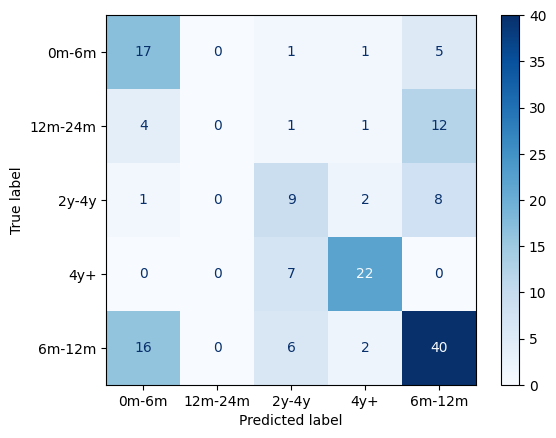

Accuracy: 0.567741935483871
Balanced accuracy: 0.5083908045977011


In [26]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

# MY OWN FEATURE SET 5.0

In [27]:
features_derived = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3']

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [28]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
277 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.49      0.79      0.60        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.38      0.45      0.41        20
         4y+       0.81      0.76      0.79        29
      6m-12m       0.65      0.66      0.65        64

    accuracy                           0.59       155
   macro avg       0.46      0.53      0.49       155
weighted avg       0.54      0.59      0.56       155



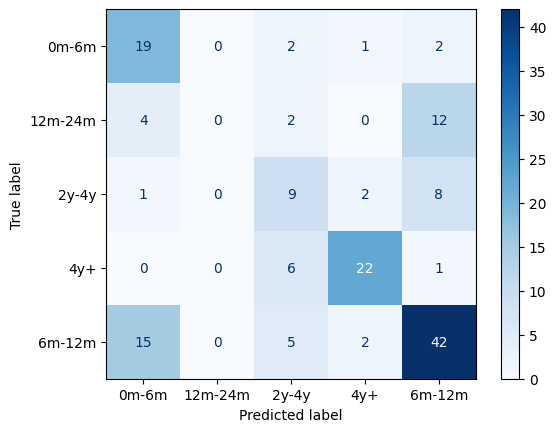

Accuracy: 0.5935483870967742
Balanced accuracy: 0.5313074712643677


In [29]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

# MY FEATURE SET 6.0

In [30]:
features_derived = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11']

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [31]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
224 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.38      0.62      0.48        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.38      0.45      0.41        20
         4y+       0.79      0.76      0.77        29
      6m-12m       0.56      0.56      0.56        64

    accuracy                           0.53       155
   macro avg       0.42      0.48      0.44       155
weighted avg       0.49      0.53      0.50       155



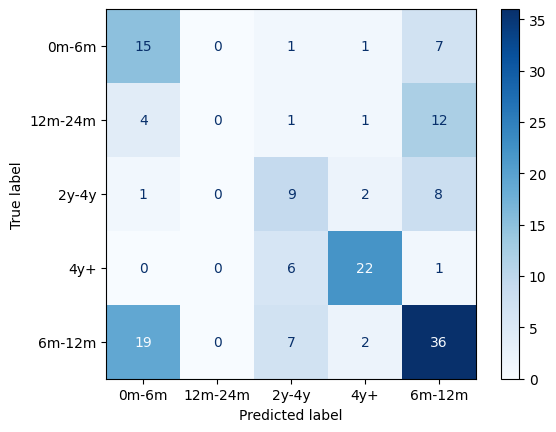

Accuracy: 0.5290322580645161
Balanced accuracy: 0.47922413793103447


In [32]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

# MY FEATURE SET 7.0

In [33]:
features_derived = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c']

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [34]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
242 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.45      0.75      0.56        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.38      0.40      0.39        20
         4y+       0.81      0.72      0.76        29
      6m-12m       0.63      0.66      0.64        64

    accuracy                           0.57       155
   macro avg       0.45      0.51      0.47       155
weighted avg       0.53      0.57      0.55       155



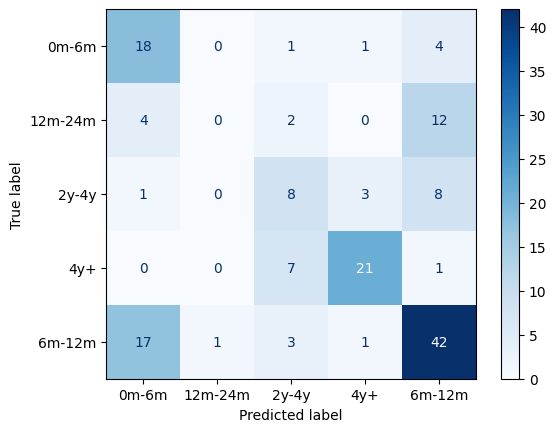

Accuracy: 0.5741935483870968
Balanced accuracy: 0.5060775862068965


In [35]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))

# MY FEATURE SET 8.0

In [36]:
features_derived = ['genome_lrtt', 'gag_lrtt', 'pol_lrtt', 'gp120_lrtt',
                    'gp120_maf12c', 'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 
                    'genome_maf12c', 'gp120_ambig', 
                    'lrtt_coeff_1', 'lrtt_coeff_3', 'genome_ambig']

# DEFINE X AND Y 
X_train = train[features_derived]
y_train = train['TSI_category']
X_test = test[features_derived]
y_test = test['TSI_category']

In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
252 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

       0m-6m       0.43      0.75      0.55        24
     12m-24m       0.00      0.00      0.00        18
       2y-4y       0.33      0.35      0.34        20
         4y+       0.76      0.76      0.76        29
      6m-12m       0.65      0.62      0.63        64

    accuracy                           0.56       155
   macro avg       0.43      0.50      0.46       155
weighted avg       0.52      0.56      0.53       155



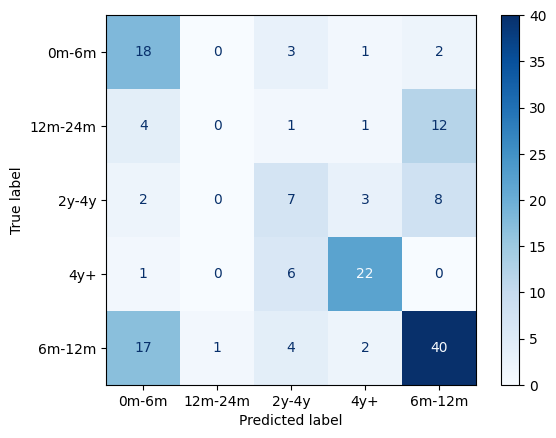

Accuracy: 0.5612903225806452
Balanced accuracy: 0.4967241379310344


In [38]:
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/multiclass/confusion_matrix.png')
plt.show()

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))